In [28]:
import torch
import numpy as np
import torch.nn.functional as F

In [32]:
x = torch.arange(60, dtype=torch.float).reshape(2, 6, 5)
# x = x.reshape(2, 5, 3)
# x = x.reshape(2, 3, 5).transpose(1, 2)

In [34]:
F.max_pool1d(x, 5).type()

'torch.FloatTensor'

In [3]:
(2,) * (x.ndim - 1)

(2,)

In [6]:
import torch.nn as nn
b = 4
a = torch.ones((b, 8, 4))
c = nn.Linear(4, 6)
c(a).shape

torch.Size([4, 8, 6])

In [35]:
import copy
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'RM_baseline')))

# from model import DoraNet
from util import *
from dataset import DoraSet, DoraSetComb

In [36]:
epochs = 500  # total epochs
local_epochs = 5 # local epochs of each user at an iteration
saveLossInterval = 1  # intervals to save loss
saveModelInterval = 10  # intervals to save model
batchSize = 500  # batchsize for training and evaluation
num_users = 90   # total users
num_activate_users = 5
lr = 3e-4  # learning rate
cudaIdx = "cuda:0"  # GPU card index
device = torch.device(cudaIdx if torch.cuda.is_available() else "cpu")
num_workers = 0  # workers for dataloader
evaluation = False  # evaluation only if True

In [38]:
folder = "./data/train/"
userlist = list(range(1, 91))
# userlist = list(range(1, 11))
datalist_size = []

for i in userlist:
    clientId = i
    data_i = np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6))
    datalist_size.append(data_i.shape[0])

min(datalist_size), max(datalist_size)

(4108, 4690)

In [3]:
folder = "./data/train/"
userlist = list(range(1, 91))
# userlist = list(range(1, 11))
datalist = []

# bs = 4
# for i in userlist:
#     clientId = i
#     data_i = np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6))
#     # data_i[:, 2:] = 10 ** (data_i[:, 2:] / 10)
#     datalist.append(data_i[data_i[:, 1 + bs] != 0, :])
#     # datalist.append(data_i)

# data = np.vstack(datalist)
# # print(data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max())
# # print(data[:, 2:].min(), data[:, 2:][data[:, 2:] != 0].max())
# plt.figure(figsize=(16, 12))
# plt.scatter(data[:, 0], data[:, 1], s=6, c=data[:, 1 + bs])
# plt.colorbar()
bs_loc = []

plt.figure(figsize=(16, 12))
for bs in range(1, 5):
    for i in userlist:
        clientId = i
        data_i = np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6))
        datalist.append(data_i[np.logical_and(data_i[:, 1 + bs] != 0, data_i[:, 1 + bs] > -62), :])
    data = np.vstack(datalist)
    loc = data[np.argmax(data[:, 1 + bs])][:2]
    bs_loc.append(loc)
    print(f'bs {bs}: {loc}')
    datalist = []
    plt.scatter(data[:, 0], data[:, 1], s=6, c=data[:, 1 + bs])
    plt.scatter(loc[0], loc[1], c='r', s=15)

plt.colorbar()

# idx 2, bs 1, bottomleft
# idx 3, bs 2, upperleft
# idx 4, bs 3, bottomright
# idx 5, bs 4, upperright

bs 1: [65.78919014 65.21920509]
bs 2: [ 65.06103647 264.39978533]
bs 3: [265.22510056  65.55262073]
bs 4: [264.8003945  265.14501625]


<Figure size 1600x1200 with 0 Axes>

In [9]:
# bsp = torch.tensor([
#     [65.78919014, 65.21920509],
#     [65.06103647, 264.39978533],
#     [265.22510056, 65.55262073],
#     [264.8003945, 265.14501625]
# ], dtype=pos.dtype, device=pos.device)

[array([65.78919014, 65.21920509]),
 array([ 65.06103647, 264.39978533]),
 array([265.22510056,  65.55262073]),
 array([264.8003945 , 265.14501625])]

In [57]:
# bs_loc
datalist = []
for i in userlist:
    clientId = i
    data_i = np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6))
    datalist.append(data_i)
data = np.vstack(datalist)

# bsl1 = []
# for loc in bs_loc:
#     loc = data[np.argmax(data[:, 1 + bs])][:2]
#     bsl1.append(data[:, :2] - loc)
# bsl1 = np.hstack(bsl1)
# bsl1.min(axis=0), bsl1.max(axis=0) 

# bsl2 = []
# for loc in bs_loc:
#     loc = data[np.argmax(data[:, 1 + bs])][:2]
#     bsl2.append(np.sqrt(np.sum((data[:, :2] - loc) ** 2, axis=1, keepdims=True)))
# bsl2 = np.hstack(bsl2)
# bsl2.min(axis=0), bsl2.max(axis=0)
# bsl2.shape

In [58]:
bs_list = []
for bs in range(1, 5):
    datalist = []
    for i in userlist:
        clientId = i
        data_i = np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6))
        datalist.append(data_i[data_i[:, 1 + bs] != 0, :])
    bs_list.append(np.vstack(datalist))

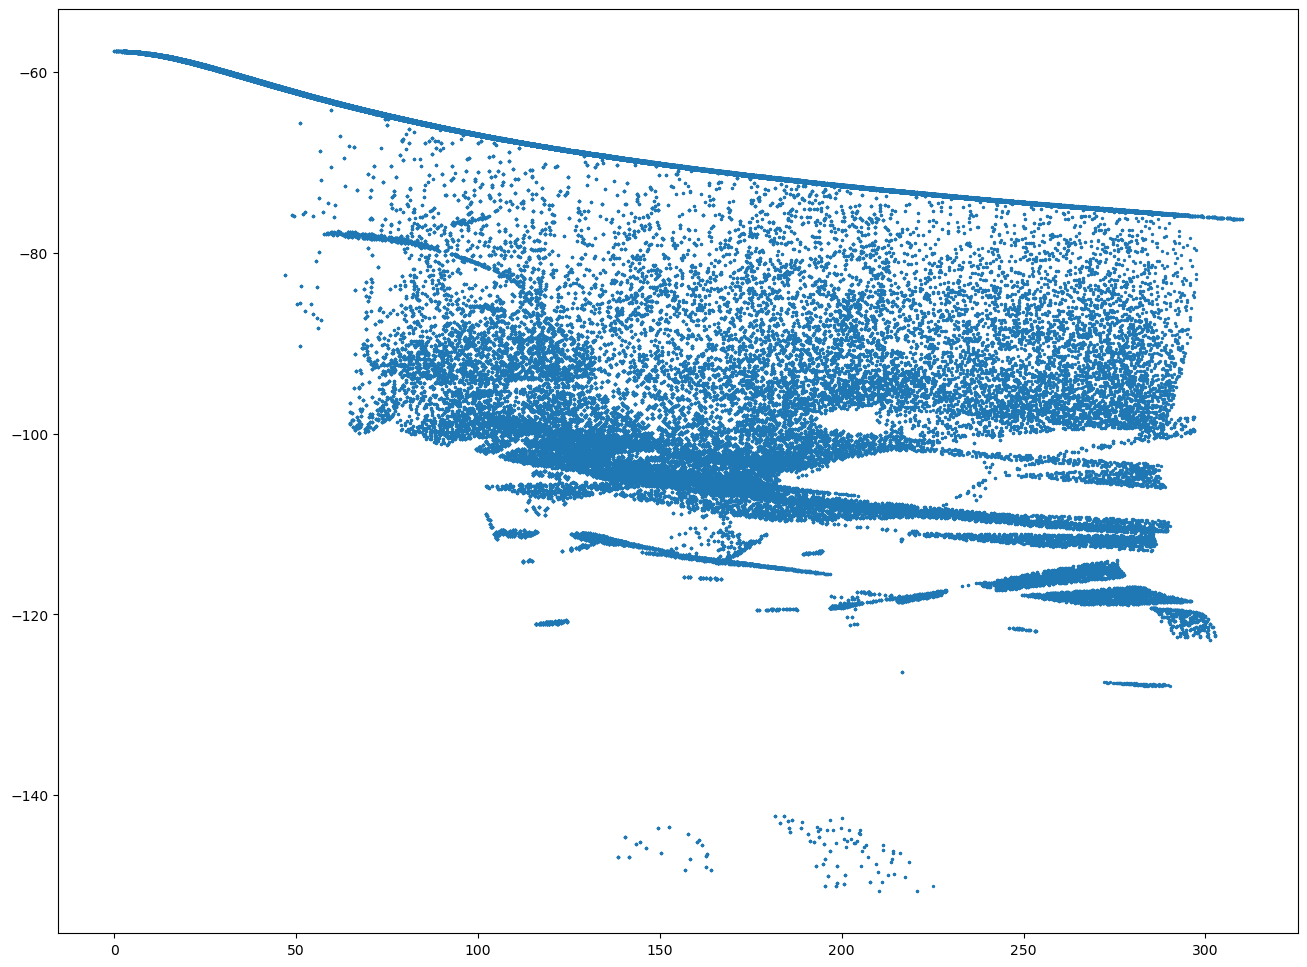

In [74]:
dissig = []
for bs in [2]:
    a = bs_list[bs - 1]
    loc = a[np.argmax(a[:, 1 + bs])][:2]
    dissig.append(np.vstack([np.linalg.norm(a[:, :2] - loc, ord=2, axis=1), a[:, 1 + bs]]).T)

dissig = np.vstack(dissig)
plt.figure(figsize=(16, 12))
plt.scatter(dissig[:, 0], dissig[:, 1], s=2)

In [3]:
model = DoraNet()
model.load_state_dict(torch.load('../tarfile/models/model500.pth'))
model.to(device)
train_dataset_path = 'data/train/'
valid_datasets = []
for i in range(1, num_users + 1):
    all_dataset = DoraSet(train_dataset_path, set='train', clientId=i)
    # train_size = int(0.99 * len(all_dataset))
    # valid_size = len(all_dataset) - train_size
    # train_dataset, valid_dataset = torch.utils.data.random_split(all_dataset, [train_size, valid_size])
    # train_datasets.append(train_dataset)
    # valid_datasets.append(valid_dataset)
    valid_datasets.append(all_dataset)

valid_data_comb = DoraSetComb(valid_datasets)
valid_loader = torch.utils.data.DataLoader(valid_data_comb, 500, shuffle=False, num_workers=num_workers)

def valid(data_loader, model):
    with torch.no_grad():
        model.eval()
        # losses = Recoder()
        # scores = Recoder()
        count = 0
        accuracy = 0
        for i, (pos, pathloss) in enumerate(data_loader):
            pos = pos.float().to(device)
            pathloss = pathloss.float().to(device)
            # p_pathloss = model(pos)
            # loss = torch.mean(torch.abs(p_pathloss[pathloss != 0] - pathloss[pathloss != 0])) ## unit in dB
            # tmp1 = torch.sum(torch.abs(10 ** (0.1 * p_pathloss[pathloss != 0]) - 10 ** (0.1 * pathloss[pathloss != 0])) ** 2)
            # tmp2 = torch.sum(torch.abs(10 ** (0.1 * pathloss[pathloss != 0])) ** 2)
            # score = tmp1 / tmp2
            # if score>1:
            #     score=torch.tensor([1])
            # losses.update(loss.item(), len(pos))
            # scores.update(score.item(), len(pos))
            pred = model(pos)
            mask = torch.where(pathloss != 0., 1., 0.).float().to(device)
            accuracy += torch.sum(pred == mask).item()
            count += mask.numel()
    # return -10 * np.log10(scores.avg())
    return accuracy / count * 100

valid(valid_loader, model)

97.29958722845134